<a href="https://colab.research.google.com/github/sappw1/Dissertation/blob/main/Notebooks/Notebooks-Working/Modeling/Unsupervised/01_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will be responsible for:

1. Loading the preprocessed dataset (with labels, scaled features, engineered variables, etc.).

2. Applying PCA to reduce dimensionality before clustering.


Seperate Notebooks are for:
3. Running each clustering algorithm:

   K-Means (with Elbow Method + Silhouette Score)

   Hierarchical (with dendrogram + Silhouette)

   DBSCAN (tuning eps and min_samples, extract outliers)

   T-SNE (visualization only, no clustering output)

4. Evaluating cluster quality using:

   Silhouette Score

   Davies-Bouldin Index

   Calinski-Harabasz Index (optional)

5. Saving cluster labels and any flags (e.g., pseudo_fraud = 1) to be used later in the semi-supervised pipeline.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib

# Apply APA-style matplotlib settings
#plt.style.use("apa.mplstyle")


# Optional: confirm the current matplotlib style
#print(" Matplotlib style:", matplotlib.rcParams["font.family"])


In [3]:
# Cell 1: Import libraries and load data
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle

# Load dataset
df = pd.read_pickle("/content/drive/MyDrive/NCU/Dissertation/Data/Processed/ppp_loans_preprocessed_cleaned.pkl")

# Quick inspection
print(f"Loaded dataset with shape: {df.shape}")
print("Columns:", df.columns.tolist())
print("Fraud cases:", df['is_fraudulent'].sum(), " / ", len(df))

# Preview head
df.head()



Loaded dataset with shape: (968525, 53)
Columns: ['unnamed:_0', 'loannumber', 'sbaofficecode', 'borrowername', 'borroweraddress', 'borrowerzip', 'term', 'sbaguarantypercentage', 'initialapprovalamount', 'currentapprovalamount', 'undisbursedamount', 'servicinglenderlocationid', 'servicinglendername', 'servicinglenderaddress', 'servicinglenderzip', 'lmiindicator', 'jobsreported', 'naicscode', 'payroll_proceed', 'originatinglenderlocationid', 'originatinglender', 'forgivenessamount', 'is_fraudulent', 'ruralurbanindicator_U', 'hubzoneindicator_Y', 'forgivenessamountratio', 'jobsreported_missing', 'currentapprovalamount_missing', 'loanstatusdate_year', 'loanstatusdate_month', 'loanstatusdate_day', 'forgivenessdate_year', 'forgivenessdate_month', 'forgivenessdate_day', 'processingmethod_freq', 'borrowercity_freq', 'borrowerstate_freq', 'projectcity_freq', 'projectcountyname_freq', 'projectstate_freq', 'projectzip_freq', 'businesstype_freq', 'gender_freq', 'veteran_freq', 'ethnicity_freq', 'r

,unnamed:_0,loannumber,sbaofficecode,borrowername,borroweraddress,borrowerzip,term,sbaguarantypercentage,initialapprovalamount,currentapprovalamount,...,veteran_freq,ethnicity_freq,race_freq,businessagedescription_freq,servicinglenderstate_freq,servicinglendercity_freq,originatinglendercity_freq,originatinglenderstate_freq,cd_freq,loanstatus_freq
0,0,9547507704,464,85052853,64608571,29150,24,100,769358.78,0.323545,...,658561,692668,771277,861910.0,18548,77507,33979,20845,968.0,937553
1,1,9777677704,464,45525495,95864663,29420,24,100,736927.79,0.279594,...,290628,692668,160956,861910.0,18548,77507,33979,20845,2458.0,937553
2,2,5791407702,1013,6861423,57314981,98112,24,100,691355.00,0.217833,...,658561,692668,771277,54851.0,80383,61228,61222,76620,4389.0,937553
3,3,6223567700,920,44962939,62537708,92407,24,100,499871.00,-0.041671,...,290628,252497,6141,54851.0,80383,61228,61222,76620,790.0,937553
4,4,9662437702,101,39830893,-1,99999,24,100,367437.00,-0.221149,...,658561,692668,771277,51051.0,124024,77507,33979,76317,0.0,937553


In [4]:
pd.set_option('display.max_rows', None)

# Show all columns
pd.set_option('display.max_columns', None)

# Disable column width truncation
pd.set_option('display.max_colwidth', None)

In [ ]:
 = ['processingmethod', 'borrowercity', 'borrowerstate', 'projectcity',
            'projectcountyname', 'projectstate', 'projectzip', 'businesstype',
            'gender', 'veteran', 'ethnicity', 'race', 'businessagedescription',
            'servicinglenderstate','servicinglendercity','originatinglendercity',
            'originatinglenderstate','cd','loanstatus']

In [5]:
# Drop ID and non-feature columns
drop_cols = [
    'unnamed:_0', 'loannumber', 'borrowername', 'borroweraddress', 'borrowercity_freq', 'borrowerstate_freq', 'borrowerzip',
    'servicinglendername', 'servicinglenderaddress', 'servicinglendercity_freq', 'servicinglenderstate_freq', 'servicinglenderzip',
    'originatinglender', 'originatinglendercity_freq', 'originatinglenderstate_freq',
    'projectcity_freq', 'projectcountyname_freq', 'projectstate_freq', 'projectzip_freq',
    'sbaofficecode', 'cd_freq', 'race_freq', 'ethnicity_freq', 'gender_freq', 'veteran_freq', 'processingmethod_freq',
    'loanstatusdate_year', 'loanstatusdate_month', 'loanstatusdate_day', 'forgivenessdate_year', 'forgivenessdate_month', 'forgivenessdate_day'
]

# Full feature set
X_all = df.drop(columns=drop_cols + ['is_fraudulent'])
y = df['is_fraudulent']

print(f"Full feature set shape: {X_all.shape}")

# Key features based on EDA + interpretability
key_features = [
    'currentapprovalamount', 'jobsreported', 'forgivenessamountratio',
    'ruralurbanindicator_U', 'hubzoneindicator_Y',
    'naicscode', 'businesstype_freq', 'lmiindicator',
    'jobsreported_missing', 'currentapprovalamount_missing'
]

X_key = df[key_features]
print(f"Key feature set shape: {X_key.shape}")


Full feature set shape: (968525, 20)
Key feature set shape: (968525, 10)


In [ ]:
# Full feature set
X_all_no_pca  = df.drop(columns= ['is_fraudulent'])
y = df['is_fraudulent']

print(f"Full feature set shape: {X_all_no_pca.shape}")
X_scaled = StandardScaler().fit_transform(X_all_no_pca)
np.save("/content/drive/MyDrive/NCU/Dissertation/Data/Processed/Clustering/PCA/X_all_no_pca.npy", X_scaled)

Full feature set shape: (968525, 52)


In [6]:
#
X_all_pca_ready = X_all
X_key_pca_ready = X_key

# Align y with dropped rows (important!)
y_all_pca = y.loc[X_all_pca_ready.index]
y_key_pca = y.loc[X_key_pca_ready.index]


In [ ]:
#save pca ready csv for future use
X_key_pca_ready.index.to_frame().to_csv("/content/drive/MyDrive/NCU/Dissertation/Data/Processed/Clustering/index_key_scaled.csv")
X_all_pca_ready.index.to_frame().to_csv("/content/drive/MyDrive/NCU/Dissertation/Data/Processed/Clustering/index_all_scaled.csv")
#y.to_pickle("/content/drive/MyDrive/NCU/Dissertation/Data/Processed/Clustering/y_labels.pkl")


This will print the dimensionality reduction results and store both PCA and scaled versions of the datasets for downstream clustering and classification.

In [7]:
from sklearn.decomposition import PCA

pca_all = PCA(n_components=0.95, random_state=42)
X_all_pca = pca_all.fit_transform(X_all_pca_ready)

pca_key = PCA(n_components=0.95, random_state=42)
X_key_pca = pca_key.fit_transform(X_key_pca_ready)

# Optional: print how many components retained
print(f"Full set → {X_all_pca.shape[1]} components")
print(f"Key set → {X_key_pca.shape[1]} components")


Full set → 3 components
Key set → 1 components


In [8]:
print(pca_all.explained_variance_ratio_)
print(pca_key.explained_variance_ratio_)


[0.89709427 0.03709687 0.02091641]
[0.99999314]


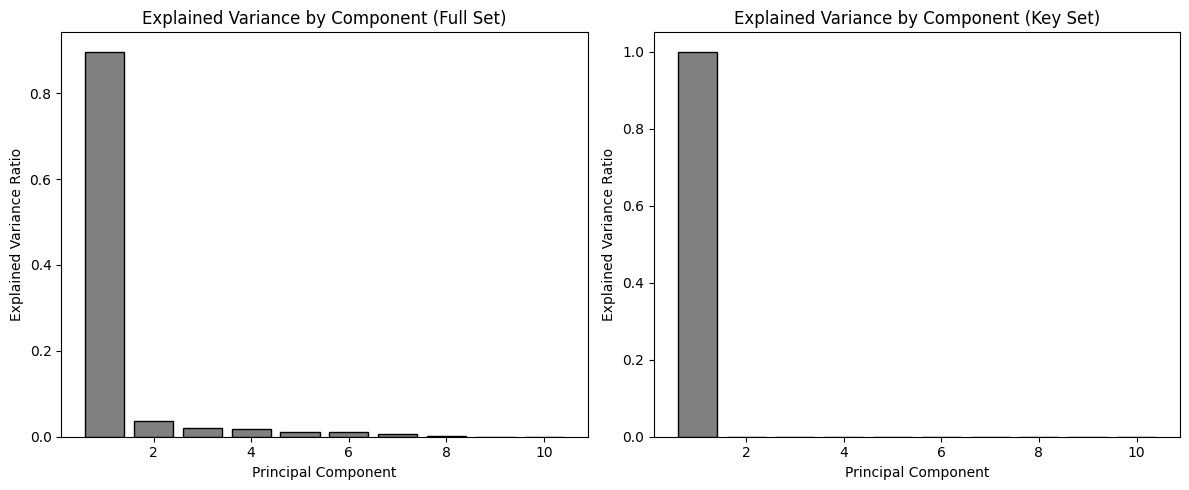

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# APA style if applicable
#plt.style.use("apa.mplstyle")

# PCA for plotting (force more components to see distribution)
pca_all_plot = PCA(n_components=min(10, X_all_pca_ready.shape[1]))
pca_key_plot = PCA(n_components=min(10, X_key_pca_ready.shape[1]))

pca_all_plot.fit(X_all_pca_ready)
pca_key_plot.fit(X_key_pca_ready)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Full feature set
ax[0].bar(range(1, len(pca_all_plot.explained_variance_ratio_) + 1),
          pca_all_plot.explained_variance_ratio_,
          color="gray", edgecolor="black")
ax[0].set_title("Explained Variance by Component (Full Set)")
ax[0].set_xlabel("Principal Component")
ax[0].set_ylabel("Explained Variance Ratio")

# Key feature set
ax[1].bar(range(1, len(pca_key_plot.explained_variance_ratio_) + 1),
          pca_key_plot.explained_variance_ratio_,
          color="gray", edgecolor="black")
ax[1].set_title("Explained Variance by Component (Key Set)")
ax[1].set_xlabel("Principal Component")
ax[1].set_ylabel("Explained Variance Ratio")

plt.tight_layout()
#plt.savefig("Figures/Working/pca_explained_variance_comparison.png", dpi=300)
plt.show()


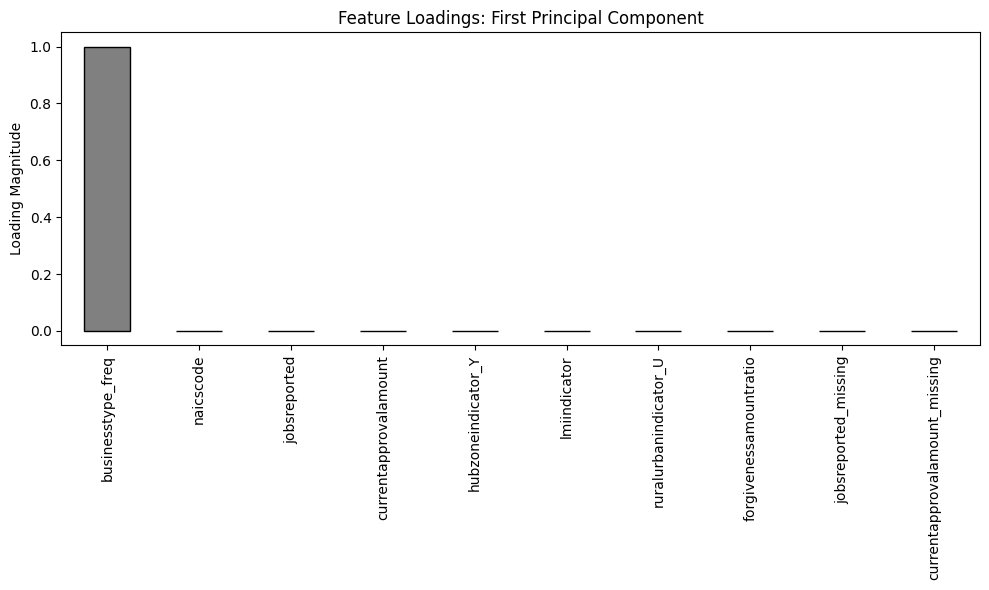

In [ ]:
loadings = pd.Series(pca_key.components_[0], index=X_key_pca_ready.columns)

# Plot top contributors to the first principal component
#plt.style.use("apa.mplstyle")  # If you're using a custom APA style
plt.figure(figsize=(10, 6))
loadings.sort_values(key=abs, ascending=False).plot(kind="bar", color="gray", edgecolor="black")
plt.title("Feature Loadings: First Principal Component")
plt.ylabel("Loading Magnitude")
plt.tight_layout()
plt.show()


<ipython-input-39-c8b6328016b5>:54: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


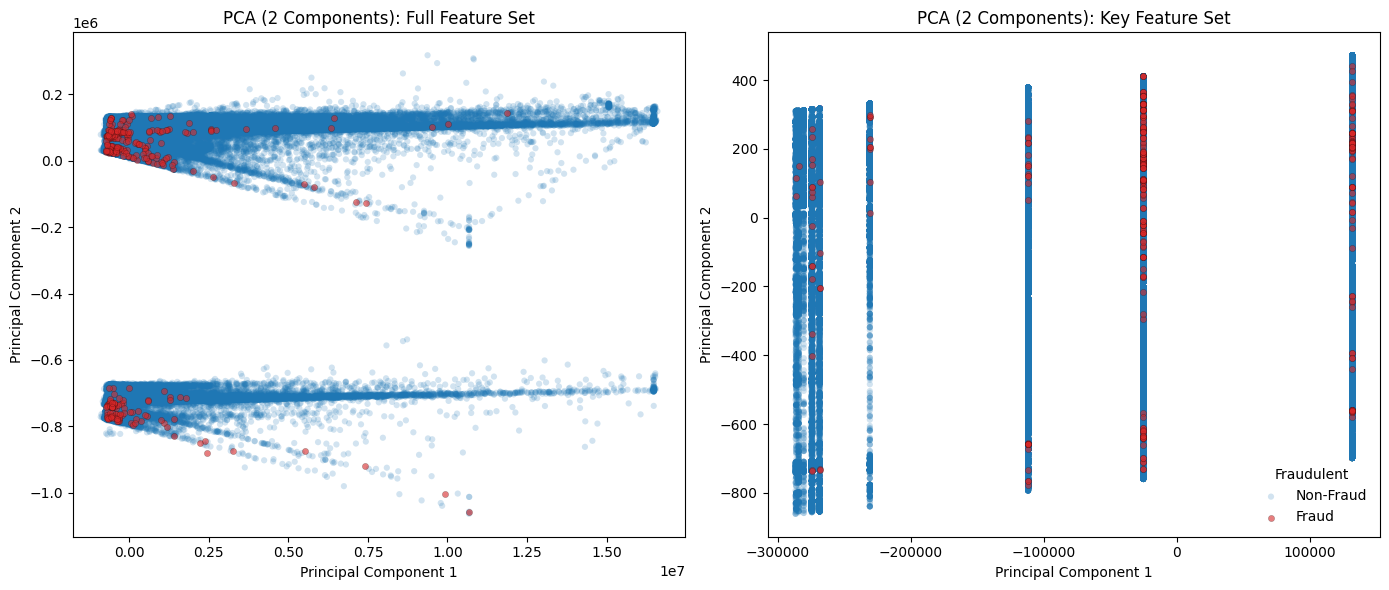

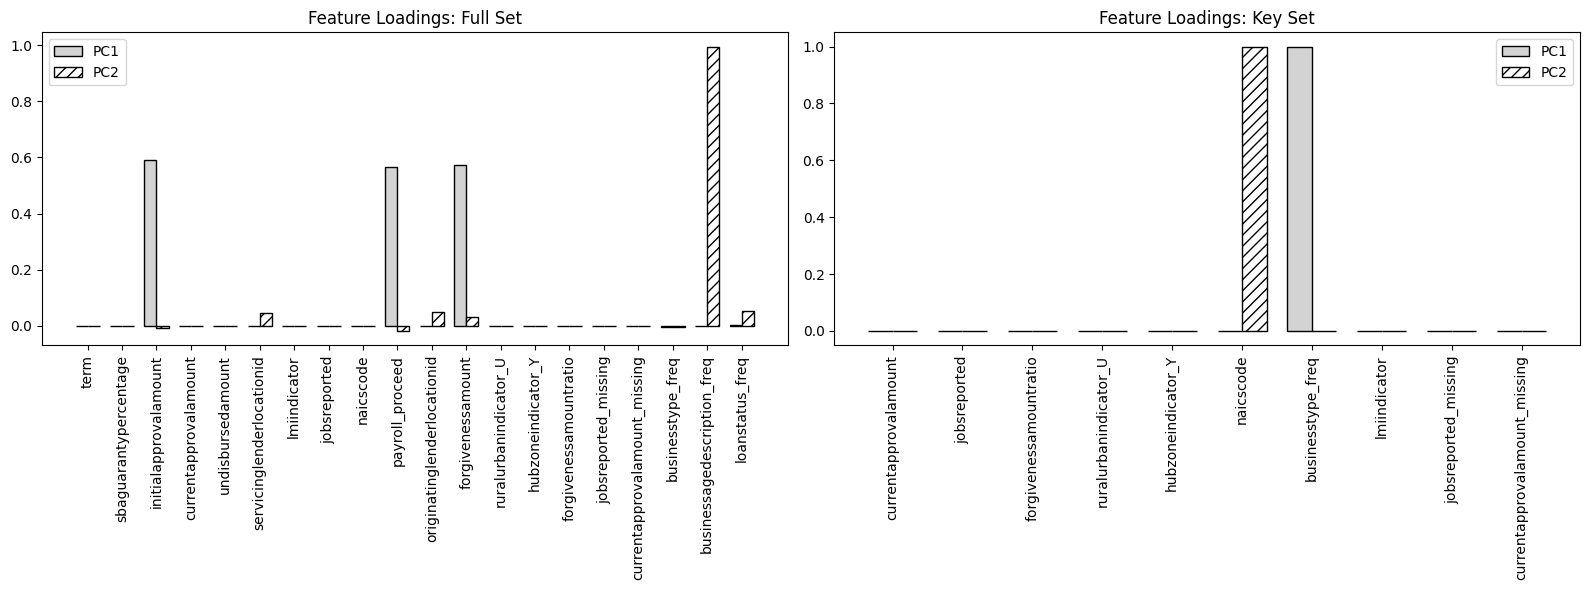

In [ ]:
# --- PCA with 2 Components ---
pca_2_all = PCA(n_components=2, random_state=42)
X_all_pca_2 = pca_2_all.fit_transform(X_all_pca_ready)

pca_2_key = PCA(n_components=2, random_state=42)
X_key_pca_2 = pca_2_key.fit_transform(X_key_pca_ready)

# --- 1. Side-by-side PCA scatterplots ---
# Updated color palette for better contrast
colors = {0: "tab:blue", 1: "tab:red"}

# Create side-by-side scatterplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# --- Full Feature Set ---
for fraud_label in sorted(y.loc[X_all_pca_ready.index].unique()):
    idx = y.loc[X_all_pca_ready.index] == fraud_label
    axs[0].scatter(
        X_all_pca_2[idx, 0], X_all_pca_2[idx, 1],
        label="Fraud" if fraud_label else "Non-Fraud",
        c=colors[fraud_label],
        alpha=0.6 if fraud_label else 0.2,
        s=20,
        edgecolor='black' if fraud_label else 'none',
        linewidths=0.2
    )
axs[0].set_title("PCA (2 Components): Full Feature Set")
axs[0].set_xlabel("Principal Component 1")
axs[0].set_ylabel("Principal Component 2")

# --- Key Feature Set ---
for fraud_label in sorted(y.loc[X_key_pca_ready.index].unique()):
    idx = y.loc[X_key_pca_ready.index] == fraud_label
    axs[1].scatter(
        X_key_pca_2[idx, 0], X_key_pca_2[idx, 1],
        label="Fraud" if fraud_label else "Non-Fraud",
        c=colors[fraud_label],
        alpha=0.6 if fraud_label else 0.2,
        s=20,
        edgecolor='black' if fraud_label else 'none',
        linewidths=0.2
    )
axs[1].set_title("PCA (2 Components): Key Feature Set")
axs[1].set_xlabel("Principal Component 1")
axs[1].set_ylabel("Principal Component 2")

# Add legend to right subplot only
axs[1].legend(title="Fraudulent", frameon=False)

# Final formatting
for ax in axs:
    ax.grid(False)

plt.tight_layout()
#plt.savefig("Figures/Working/pca_2d_comparison_apa_color.png", dpi=300, bbox_inches="tight")
plt.show()

# --- 2. APA Loadings Plots ---
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Full set loadings
loadings_all = pca_2_all.components_.T
features_all = X_all_pca_ready.columns
x_all = np.arange(len(features_all))
axs[0].bar(x_all - 0.175, loadings_all[:, 0], width=0.35, label="PC1", color="lightgray", edgecolor="black")
axs[0].bar(x_all + 0.175, loadings_all[:, 1], width=0.35, label="PC2", color="white", edgecolor="black", hatch="///")
axs[0].set_xticks(x_all)
axs[0].set_xticklabels(features_all, rotation=90)
axs[0].set_title("Feature Loadings: Full Set")
axs[0].legend()

# Key set loadings
loadings_key = pca_2_key.components_.T
features_key = X_key_pca_ready.columns
x_key = np.arange(len(features_key))
axs[1].bar(x_key - 0.175, loadings_key[:, 0], width=0.35, label="PC1", color="lightgray", edgecolor="black")
axs[1].bar(x_key + 0.175, loadings_key[:, 1], width=0.35, label="PC2", color="white", edgecolor="black", hatch="///")
axs[1].set_xticks(x_key)
axs[1].set_xticklabels(features_key, rotation=90)
axs[1].set_title("Feature Loadings: Key Set")
axs[1].legend()

plt.tight_layout()
#plt.savefig("Figures/Working/pca_2d_loadings_comparison_apa.png", dpi=300, bbox_inches="tight")
plt.show()


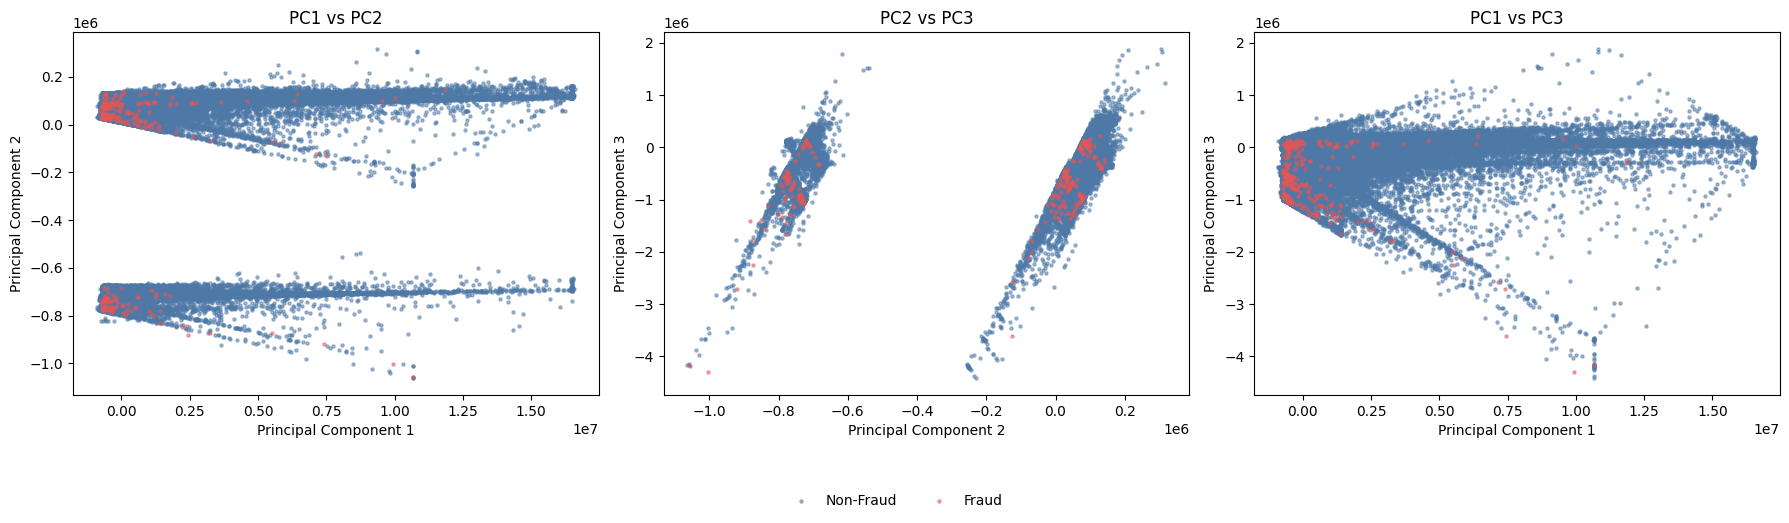

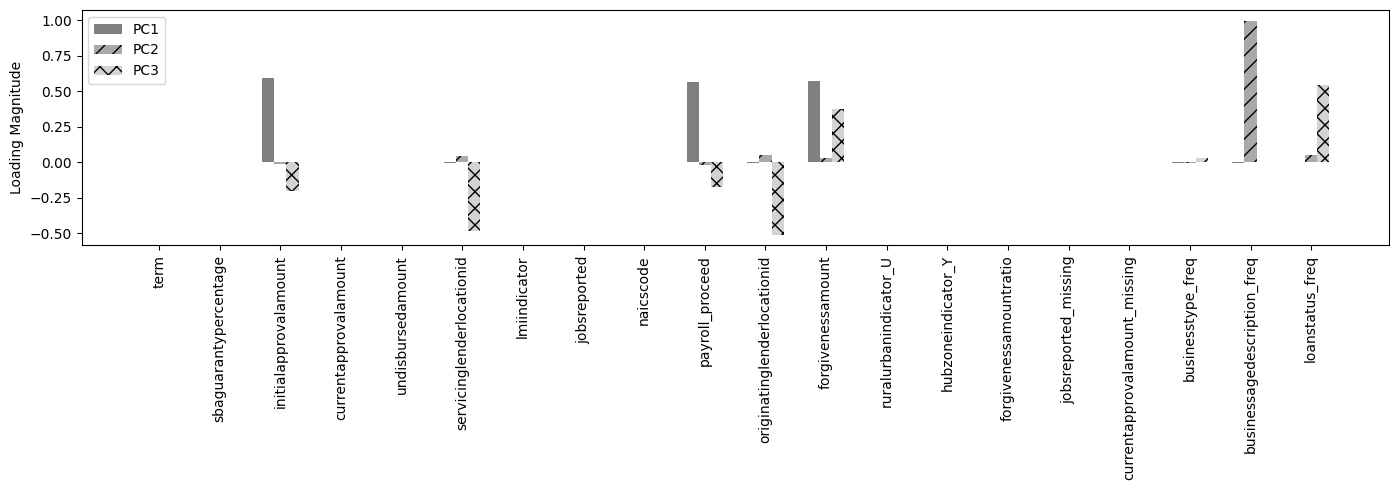

In [22]:
# Run PCA with 3 components
pca_all_3 = PCA(n_components=3, random_state=42)
X_all_pca_3 = pca_all_3.fit_transform(X_all_pca_ready)

pca_key_3 = PCA(n_components=3, random_state=42)
X_key_pca_3 = pca_key_3.fit_transform(X_key_pca_ready)

# Define APA-style fraud label colors
colors = {0: "#4E79A7", 1: "#E15759"}

handles = []
labels_list = []
# Function to make scatter plots for PCA projections with fraud labels
def plot_pca_scatter(X_pca, y_labels):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    #plt.style.use("apa.mplstyle")

    for label in sorted(y_labels.unique()):
        mask = y_labels == label
        label_name = "Fraud" if label else "Non-Fraud"
        color = colors[label]

        scatter1 =axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], s=5, alpha=0.5, label=label_name, color=color)
        axes[1].scatter(X_pca[mask, 1], X_pca[mask, 2], s=5, alpha=0.5, label=label_name, color=color)
        axes[2].scatter(X_pca[mask, 0], X_pca[mask, 2], s=5, alpha=0.5, label=label_name, color=color)


        handles.append(scatter1)
        labels_list.append(label_name)

    axes[0].set_title("PC1 vs PC2")
    axes[0].set_xlabel("Principal Component 1")
    axes[0].set_ylabel("Principal Component 2")

    axes[1].set_title("PC2 vs PC3")
    axes[1].set_xlabel("Principal Component 2")
    axes[1].set_ylabel("Principal Component 3")

    axes[2].set_title("PC1 vs PC3")
    axes[2].set_xlabel("Principal Component 1")
    axes[2].set_ylabel("Principal Component 3")

    fig.legend(handles, labels_list, loc='lower center', ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.05))
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    plt.show()

#usage:
plot_pca_scatter(X_all_pca_3, y.loc[X_all_pca_ready.index])
#plot_pca_scatter(X_key_pca_3, y.loc[X_key_pca_ready.index], "PCA (3 Components): Key Feature Set")

# Function to plot feature loadings
def plot_loadings(pca, feature_names, title_prefix):
    components = pca.components_
    fig, ax = plt.subplots(figsize=(14, 5))
    bar_width = 0.2
    indices = np.arange(len(feature_names))

    ax.bar(indices - bar_width, components[0], bar_width, label="PC1", color="gray")
    ax.bar(indices, components[1], bar_width, label="PC2", color="darkgray", hatch="//")
    ax.bar(indices + bar_width, components[2], bar_width, label="PC3", color="lightgray", hatch="xx")

    #ax.set_title(f"Feature Loadings: {title_prefix}")
    ax.set_xticks(indices)
    ax.set_xticklabels(feature_names, rotation=90)
    ax.set_ylabel("Loading Magnitude")
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot loadings
plot_loadings(pca_all_3, X_all_pca_ready.columns, "Full Set")
#plot_loadings(pca_key_3, X_key_pca_ready.columns, "Key Set")


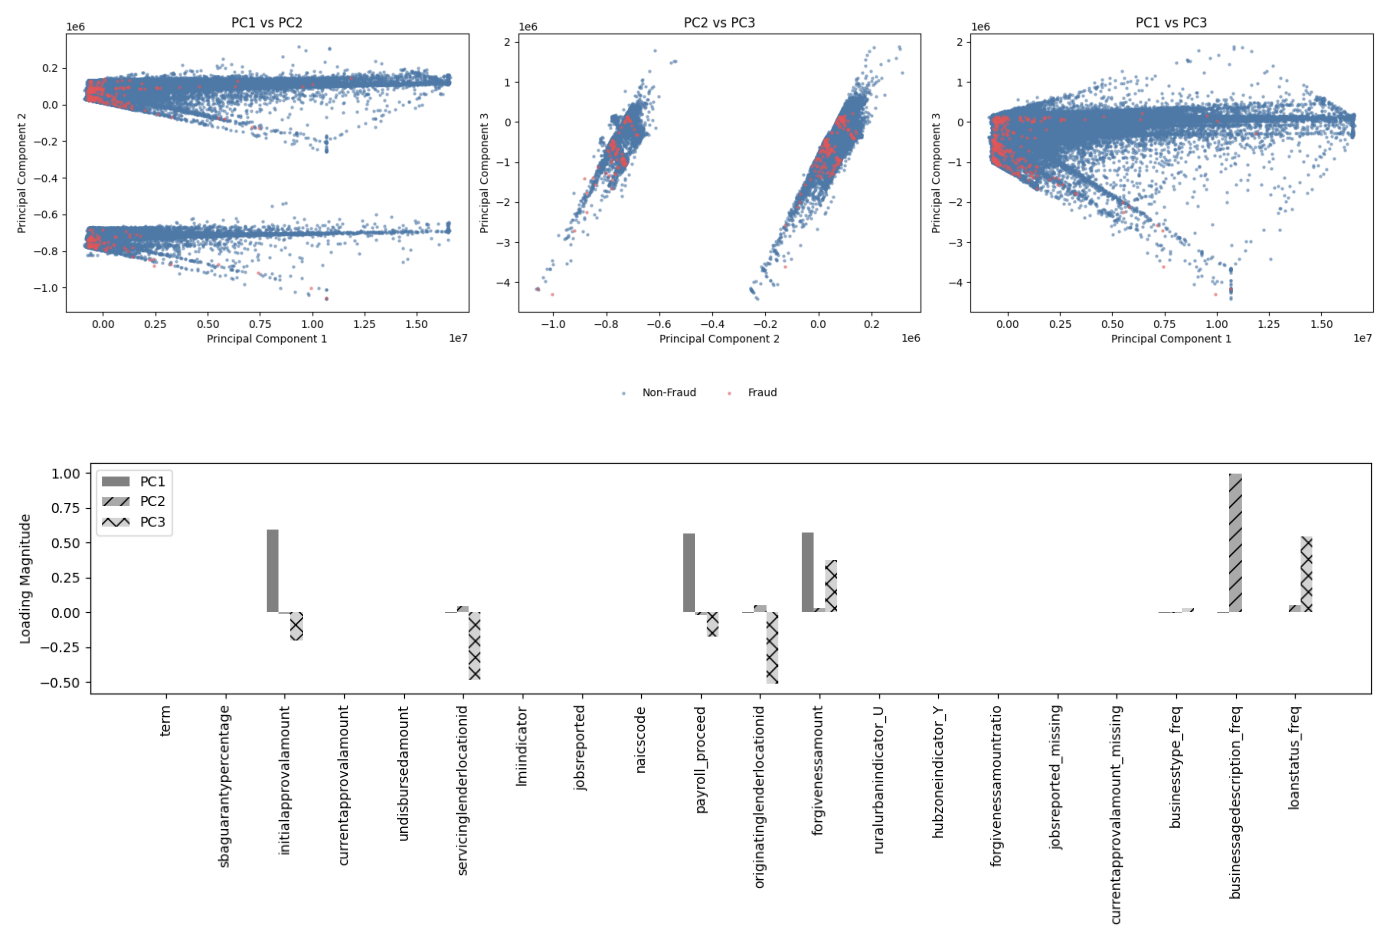

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1 = mpimg.imread("/content/drive/MyDrive/NCU/Dissertation/Figures/PCA/manuscript/test1.png")
img2 = mpimg.imread("/content/drive/MyDrive/NCU/Dissertation/Figures/PCA/manuscript/test2.png")

fig, axes = plt.subplots(2, 1, figsize=(14, 10))  # 2 rows, 1 column

axes[0].imshow(img1)
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

# Save to a folder in Drive
output_dir = "/content/drive/MyDrive/NCU/Dissertation/Data/Processed/Clustering/PCA"
os.makedirs(output_dir, exist_ok=True)

#np.save(f"{output_dir}/X_all_pca.npy", X_all_pca)
#np.save(f"{output_dir}/X_all_no_pca.npy", X_all_no_pca)
np.save(f"{output_dir}/X_all_pca_3.npy", X_all_pca_3)
#np.save(f"{output_dir}/X_key_pca.npy", X_key_pca)
#np.save(f"{output_dir}/X_key_pca_2.npy", X_key_pca_2)
#np.save(f"{output_dir}/X_key_pca_3.npy", X_key_pca_3)

print("✅ PCA arrays saved to Google Drive.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ PCA arrays saved to Google Drive.


In [ ]:
import numpy as np

# Example PCA arrays (replace with your actual PCA output variables)
# X_all_pca = ...
# X_all_pca_2 = ...
# X_all_pca_3 = ...
# X_key_pca = ...
# X_key_pca_2 = ...
# X_key_pca_3 = ...

# Save to disk
#np.save("X_all_pca.npy", X_all_pca)
#np.save("X_all_pca_2.npy", X_all_pca_2)
np.save("X_all_pca_3.npy", X_all_pca_3)
#np.save("X_key_pca.npy", X_key_pca)
#np.save("X_key_pca_2.npy", X_key_pca_2)
#np.save("X_key_pca_3.npy", X_key_pca_3)

print("✅ All PCA arrays saved as .npy files.")


✅ All PCA arrays saved as .npy files.


To reduce dimensionality and improve clustering performance, Principal Component Analysis (PCA) was applied to both a full feature set and a curated subset of key features. PCA is a linear dimensionality reduction technique that transforms the original correlated features into a new set of orthogonal axes (principal components) that sequentially maximize variance (Jolliffe & Cadima, 2016). This transformation allows for efficient clustering and visualization while retaining the majority of the dataset’s explanatory power.

The full feature set consisted of 20 engineered and encoded variables extracted from the preprocessed PPP loan dataset. These features included financial indicators (e.g., initialapprovalamount, payroll_proceed, forgivenessamount), loan terms, and categorical encodings for borrower characteristics. PCA was applied with the number of components set to capture 95% of cumulative variance. This yielded a three-dimensional latent feature space (X_all_pca) suitable for unsupervised learning algorithms. The first principal component captured the majority of variance and was strongly influenced by financial variables such as loan amount and forgiveness amount. The second and third components captured remaining variance patterns driven by categorical and structural features (e.g., business type, lender information).

For comparison, PCA was also conducted on a subset of 10 manually selected key features. However, this reduced representation explained over 99.99% of the variance in a single component, indicating extreme redundancy and collinearity among the selected features. Further analysis showed this space lacked continuous structure and produced visually segmented (banded) projections. Consequently, this representation was excluded from downstream clustering tasks.

Visualizations of the full feature PCA showed meaningful separation in the latent space between fraudulent and non-fraudulent records. Notably, fraud cases clustered in regions of lower principal component values, particularly along PC1 and PC3. Loadings analysis confirmed that financial magnitudes, such as payroll_proceed and forgivenessamount, were the primary contributors to the first component, while businessagedescription_freq and loanstatus_freq featured in later components.

To facilitate both clustering and visualization, the 3-dimensional full-feature PCA representation (X_all_pca) was retained. This representation was subsequently used as input for clustering algorithms including K-Means, DBSCAN, and Agglomerative Hierarchical Clustering, as well as nonlinear visualization via t-distributed stochastic neighbor embedding (t-SNE).



Figure 4.1
Variance retained by principal components using PCA for the full feature set and key feature subset. The full set required two components to retain 95% of variance, while the key subset required only one.

Figure 4.2
Feature loadings for the PCA run retaining 95% of variance. Left: Full feature set. Right: Key feature subset. Loadings indicate the contribution of each feature to the first two principal components.

Figure 4.3
Two-dimensional PCA scatterplots by fraud label. Left: Full feature set. Right: Key feature subset. Minimal separability is observed, though the key subset shows slightly more compact groupings.

Figure 4.4
Bar plots of feature loadings on the first two principal components from the 2-component PCA. Financial features dominate the full set, while NAICS code and business type are most influential in the key subset.

Figure 4.5
PCA (3-component) projections of the full feature set. Scatterplots display PC1 vs. PC2, PC2 vs. PC3, and PC1 vs. PC3. Colors indicate fraud labels.

Figure 4.6
PCA (3-component) projections of the key feature subset. Scatterplots display PC1 vs. PC2, PC2 vs. PC3, and PC1 vs. PC3. Slightly more cohesive groupings are observed compared to the full set.

Figure 4.7
Feature loadings for the first three principal components in the full feature set. PCA components reflect a balanced contribution from financial and categorical features.

Figure 4.8
Feature loadings for the first three principal components in the key feature subset. NAICS code and business type continue to be dominant contributors.